# Bayesian parameter inference with the TRENTo inital condition model

## Overview of the model parameters

In this exerciese, we are going to use the Bayesian analysis technique to study the TRENTo model. 
1. Energy deposition relation: $p$
2. Nucleon size parameter: $w$ [fm]
3. Fluctuation parameter: $k$
4. Nucleon minimum-distance parameters: $d$
5. Energy density normalization: $N$


We are primarily interested in the in $p$ and $w$ parameter. Because we will only use the initial condition preidciton, some of the fluctuations that presents in the dynamical evolution will be effectively account into the $k$ value when compare to real data. Therefore, the precise value of $k$ will not be so interested. The nucleon minimum distance is also a very crude approximation for the actual repulsive core. Nevertheless, it is important to propagate the uncertainty of $k$ and $d$ into the determination of $p$ and $w$. Finally, the energy density normalization is multiplied to the energy deposition relation:

$$ \frac{de}{d\eta_s dx_\perp^2} = \tau \textrm{Norm} \times \left(\frac{T_A^p(x_\perp) + T_B^p(x_\perp)}{2}\right)^{1/p} $$ 

$$ T_{A, B}(x_\perp) =  \sum_{\textrm{participants} \in A. B} \gamma_i \rho(x_\perp-x_{\perp, i}) $$

Here, we are going to consider $N=\tau \textrm{Norm}$ as a single scale parameter. Again, its absolute value is not our interest.

## Data

Because we only studies initial condition prediciton, we will be focusing on two data set that are rather insensitive to the dynamical evolution, and more directly related to the initial condition. 

1. Total transverse energy as function of centrality at mid-rapidity $\sum E_T$ v.s. Centrality. Assume boost-incariance of the initial condition and the following dynamics on the rapidity distribution. The total energy deposited in initial condition is a good approximation of the final-state total transverse energy at mid-rapidity.

2. The scaled flow distribution $P(v_n/\langle v_n \rangle)$. This distributino is shown to be closely correlated with initial eccenticity distributions (assumes linear reponse of the dynamics) $P(\epsilon_n / \langle \epsilon_n \rangle)$.

### Pseudo-data

We will first apply the Bayesian procedure to infer these parameter from a set of pseudo-data generate by TRENTo calcualtion where we know what the true values of the parameters are. This practice is essential before applying your model+Bayesian to real-world data. In this so-called closesure test, one gets a better understand of the uncertainties in the Bayesian procedure, as the model should preferctly describe the pseudo-data, given the corrected parameters.

### Experimental data

Centrality dependent $\sum E_T$ in Pb+Pb at $\sqrt{s}=2.76$ TeV as measured by the ALICE experiment Phys. Rev. C 94 (2016) 034903.

Flow distribution in Pb+Pb at $\sqrt{s}=2.76$ TeV as measured by the ATLAS experiment JHEP11(2013)183.

In [1]:
import subprocess
# packages for scientific computing
import numpy as np
from scipy.interpolate import interp1d
# package for plotting
import matplotlib.pyplot as plt
%matplotlib inline
# Pythonic interface to the HDF5 binary data format
import h5py
# Package for Markov chain Monte Carlo
import emcee

# scikit-learn: machine learning in Python
# https://scikit-learn.org/stable/tutorial/basic/tutorial.html
# In this example, we are using the principal component analysis 
# and the Gaussian process regression as implemented in sklearn.
# Detailed documentation of these modules:
# Principal component analysis (PCA): 
# https://scikit-learn.org/stable/modules/decomposition.html
# Gaussian process gressor (GPR)):
# https://scikit-learn.org/stable/modules/gaussian_process.html
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.gaussian_process import \
     GaussianProcessRegressor as GPR
from sklearn.gaussian_process import kernels

# suppression warning messages
import warnings
warnings.filterwarnings('ignore')

# some plot settings, not important
fontsize  = 12
plt.rcdefaults()
plt.rcParams.update({
    'font.size': fontsize,
    'legend.fontsize': fontsize,
    'axes.labelsize': fontsize,
    'axes.titlesize': fontsize,
    'xtick.labelsize': fontsize,
    'ytick.labelsize': fontsize,
    'axes.formatter.limits': (-5, 5),
    'axes.spines.top': True,
    'axes.spines.right': True,
    'legend.frameon': False,
    'image.cmap': 'Blues',
    'image.interpolation': 'none',
})


# Step 1: make design

We use the Latin hyper-cube sampling function implemented in the R program to generate unit ($0<x<1$) parameter design.

*Remark*: in principle, our parameter space is five-dimensional $p,w,k,d$ and $N$. And we should run the model on each set of the parameter to get the prediction. However, since the effect of normalization $N$ is simply additive to the intiial condition prediction to of the total energy. Therefore, there is no need to interpolate over $N$, and ut is sufficient to generate the design with only four parameters $p,w,k,d$.

In [2]:
def LHS_design(ranges, npoints, ndim, seed=12345):
    proc = subprocess.run(
        ['R', '--slave'],
        input="""
        library('lhs')
        set.seed({})
        write.table(maximinLHS({}, {}), col.names=FALSE, row.names=FALSE)
        """.format(seed, npoints, ndim).encode(),
        stdout=subprocess.PIPE,
        check=True
    )
    lhs = np.array(
        [l.split() for l in proc.stdout.splitlines()],
        dtype=float
    )
    # lhs is sampled within unit hypercube: [0,1]^ndim
    # Recale the unit design into the desired ranges
    Design = np.array([  
        (1.-x)*lower + x*upper
        for (lower, upper), x in zip(ranges, lhs.T)
    ])
    return Design

def load_existing_design(filename="ModelData/training-data/Design.dat"):
    Design = np.loadtxt(filename).T
    npoint, ndim = Design.shape
    return Design, npoint, ndim


def Random_design(ranges, npoints, ndim, seed=12345):
    # Just in case you haven't install R yet...
    np.random.seed(seed)
    unithypercube = np.random.rand(npoints, ndim)
    Design = np.array([  
        (1.-x)*lower + x*upper
        for (lower, upper), x in zip(ranges, unithypercube.T)
    ])
    return Design

The five parameters that we are going tune are:
1.   $-1 < p < 1$
2.   $.4 < p < 1.5 $ fm 
3.   $1/3 < \sigma < 3$, for fluctuation, we tune the standard deviation which is related to the $k$-parameter by $\sigma = 1/\sqrt{k}$
4.   $0<v<4$, we assume $v = d_\min^3$ has a uniform prior.
5.   $8 < N < 12$

In [3]:
ParamLabels = ["p","w","s","v","N"]
ParamTexLabels = [r"$p$",r"$w$ [fm]", 
                  r"$\sigma$", r"$v$ [fm${}^3$]",
                  r"$N$"]
RangeWithLabels = {"p": [-1, 1],
               "w": [0.4, 1.5],
               "s": [1./3., 3.],
               "v": [0, 2.],
               "N": [6,16]
                }
ranges = np.array([
        RangeWithLabels[l] for l in ParamLabels
])
ndim = len(ParamLabels)

use_existing_design = True

if not use_existing_design:
    # Design Latin-Hypercube for the first four parameters:
    NumberOfDesign = 100
    Design = LHS_design(ranges[:4], NumberOfDesign, ndim=4)

else:
    Design, NumberOfDesign, _ = load_existing_design()
RandomDesign = Random_design(ranges[:4],100, ndim=ndim)
print(Design.shape)

(4, 100)


Check the distribution of the design parameters
1. Single parameter distribution should be uniform
2. Pair-wise distribution covers the 2D range

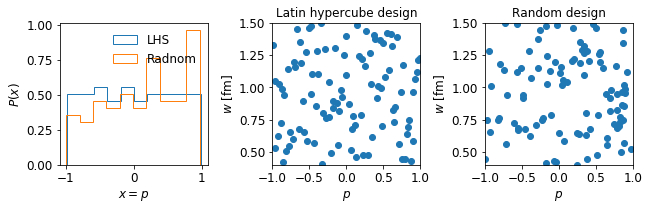

In [4]:
fig, (ax1, ax2, ax3) = plt.subplots(ncols=3, figsize=(9,3))

ax1.hist(Design[0], bins=10, histtype='step', 
         density=True, label='LHS')
ax1.hist(RandomDesign[0], bins=10, histtype='step', 
         density=True, label='Radnom')
ax1.legend()
ax1.set_xlabel(r"$x=$"+ParamTexLabels[0])
ax1.set_ylabel(r"$P(x)$")

ax2.scatter(Design[0], Design[1])
ax2.axis([*ranges[0], *ranges[1]])
ax2.set_xlabel(ParamTexLabels[0])
ax2.set_ylabel(ParamTexLabels[1])
ax2.set_title("Latin hypercube design")

ax3.scatter(RandomDesign[0],RandomDesign[1])
ax3.axis([*ranges[0], *ranges[1]])
ax3.set_xlabel(ParamTexLabels[0])
ax3.set_ylabel(ParamTexLabels[1])
ax3.set_title("Random design")

plt.tight_layout(True)

## Step 2: Running the physical model on design parameters and compute the observables

For a complex mode, this step is the most time consuming piece of the Bayesian analysis. Even though we only use initial condition model to make predictions (TRENTo O(100) events/s, versus full model, O(10) events / hour), it is still time consuming if you have to generated tens of thousands of events using each of the 100 different parameter set. Therefore, we will just load pre-generated TRENTo data / observables at the hands-on session. 

*Remark* when you do the calcualtion on your own, it is always good to estimate the computing time when planning the design points.

In [5]:
# Function that calls TRENTo to generate events, looping over
# each set of design parameters
# *Will not be used during this hands-on session
TRENTo_dtype=[('idx',np.int,1),
              ('b', np.float,1),
              ('npart', np.int,1),
              ('ET', np.float,1),
              ('e2', np.float,1),  
              ('e3', np.float,1),  
              ('e4', np.float,1),  
              ('e5', np.float,1),  
             ]
def call_TRENTo(p, w, s, v, 
                Nevents=10000, save2file="trento-data.h5"):
    for i, (ip, iw, isigma, iv) in enumerate(zip(p, w, s, v)):
        print("Generating point ", i, 
              " p={:1.3f}, w={:1.3f}, sigma={:1.3f}, v={:1.3f}".format(ip, iw, isigma, iv)
             )
        proc = subprocess.run(
            ['trento', 
             'Pb','Pb', '{:d}'.format(Nevents),
             '-x','6.4', 
             '-n','1.0',
             '-p','{:1.3f}'.format(ip), 
             '-w','{:1.3f}'.format(iw), 
             '-k','{:1.3f}'.format(1/isigma**2), 
             '-d','{:1.3f}'.format(iv**(1./3.)), 
            ],
            stdout=subprocess.PIPE
        )
        results = []
        for l in proc.stdout.splitlines():
            e1 = np.empty(1,dtype=TRENTo_dtype)
            for it, value in zip(TRENTo_dtype, l.split()):
                e1[it[0]] = value
            results.append(e1[0])
        results = np.array(results)
        with h5py.File(save2file,'a') as f:
            groupname = "{:d}/".format(i)
            #if groupname in f:
            #    del f[groupname]
            g = f.create_group(groupname)
            g.attrs['p'] = ip
            g.attrs['w'] = iw            
            g.attrs['s'] = isigma
            g.attrs['v'] = iv
            for it, value in zip(TRENTo_dtype[1:], l.split()[1:]):
                g.create_dataset(it[0], data=results[it[0]], dtype=it[1])    

In [6]:
# *Will not be used during this hands-on session
#call_TRENTo(Design[0], Design[1], Design[2], Design[3], Nevents=1000,)

Load the calcualtion and compute observabeles:
1. Centrality is defined by $\sum E_T$ in the calculation.
2. The full distribution $P(\epsilon_n/\langle \epsilon_n \rangle)$ requires very high statistics. So instead, we will compare the width (std) and skewness of the distribution to experiments.

In [7]:
def std_and_skewness_with_uncertainty(x):
    n = len(x)
    std1 = np.sqrt( ((x-x.mean())**2).mean() )
    skew1 = ((x-x.mean())**3).mean() / std1**3
    std = np.sqrt(n/(n-1)) * std1
    std_err = std/np.sqrt(2*n-2)
    skew = np.sqrt(n*(n-1))/(n-1) * skew1
    skew_err= np.sqrt(6*n*(n-1)/((n-2)*(n+1)*(n+3)))
    return std, std_err, skew, skew_err

def LoadAndComputeObs(filename="ModelData/trento-data/design-raw.h5"):
    obs = {}
    with h5py.File(filename, "r") as f:
        for i in range(len(list(f.keys()))):
            it = "{:d}".format(i)
            obs[it] = {}
            ET = f[it]['ET'].value
            # sort events with ET
            index = np.argsort(ET)[::-1]
            ET = ET[index]
            e2 = f[it]['e2'].value[index]
            e3 = f[it]['e3'].value[index]
            e4 = f[it]['e4'].value[index]
            Nevents = len(ET)
            cen = np.array([0, 2.5, 5, 7.5, 10, 
                            12.5, 15, 17.5, 20, 
                            22.5, 25, 27.5, 30, 
                            32.5, 35, 37.5, 40, 
                            45, 50, 55, 60, 
                            65, 70, 75, 80])
            cenidx = (cen/100.*Nevents).astype(int)
            obs[it]['ET']={
                'x': (cen[1:]+cen[:-1])/2.,
                'xbin': cen,
                'y': np.array([
                    ET[il:ih].mean()
                    for il, ih in zip(cenidx[:-1],cenidx[1:])
                ]),
                'stat': np.array([
                    ET[il:ih].std()/np.sqrt(ih-il-1)
                    for il, ih in zip(cenidx[:-1],cenidx[1:])
                ])
            }

            for n, data in zip([2,3,4], [e2, e3, e4]):
                for (cl, ch) in [(20,25),(40,45)]:
                    i1 = int(cl/100.*Nevents)
                    i2 = int(ch/100.*Nevents)
                    x = data[i1:i2]/data[i1:i2].mean()
                    H, bins = np.histogram(x, bins=32, range=(0,3.2), density=True)
                    std, std_err, skew, skew_err = \
                        std_and_skewness_with_uncertainty(x)
                    obs[it]['Pe{:d}-{:d}-{:d}'.format(n,cl,ch)]={
                        'x': (bins[1:]+bins[:-1])/2.,
                        'y': H,
                    }
                    obs[it]['Me{:d}-{:d}-{:d}'.format(n,cl,ch)]={
                        'std': std,
                        'std-err': std_err,
                        'skew': skew,
                        'skew-err': skew_err,
                    }
    return obs

First, plot the experimental data as a reference

In [8]:
#plot experimental data as a reference
def plot_exp(axes):
    x, xl, xh, ET, ETstat, ETsys = np.loadtxt("ExpData/ALICE-ET.dat",usecols=[0,1,2,3,4,6]).T
    axes[0].errorbar(x, ET, xerr=(xh-xl)/2., yerr=ETstat,label='ALICE',fmt='k.',markersize=2)
    for (ixl, ixh, iy, iss) in zip(xl, xh, ET, ETsys):
        axes[0].fill_between([ixl,ixh],[iy-iss,iy-iss],
                    [iy+iss,iy+iss],facecolor='none',
                    edgecolor='k')
    axes[0].set_xlabel("Centrality(%)")
    axes[0].set_ylabel(r"$\sum E_T$ [GeV]]")

    cenL, cenH = 40, 45
    for ax, n in zip(axes[1:], [2,3,4]):
        x, y, stat, sp, sm = np.loadtxt("ExpData/ATLAS-Pv{}-{}-{}.dat".format(n,cenL,cenH), 
                                            usecols=[0,1,2,4,5]).T
        f = interp1d(x, y, kind='linear')
        X = np.linspace(x.min(),x.max(),100)
        xmean = (f(X)*X).sum()/f(X).sum()
        ax.errorbar(x/xmean, y*xmean, yerr=stat*xmean, label='ATLAS, \n n={:d}, {:d}-{:d}%'.format(n,cenL,cenH), fmt='k.')
        for ix, iy, ip, im in zip(x/xmean, y*xmean, sp*xmean, sm*xmean):
            ax.fill_between([ix-.02, ix+.02], [iy+im, iy+im], [iy+ip, iy+ip], edgecolor='k', facecolor='none')
        ax.legend(loc='lower left')
        ax.semilogy()
        ax.set_xlabel(r"$x$")
        ax.set_ylabel(r"$P(x)$")
        ax.set_title(r"$x = v_{}/\langle v_{} \rangle$ or $\epsilon_{}/\langle \epsilon_{} \rangle$".format(n,n,n,n))
        
    plt.tight_layout(True)

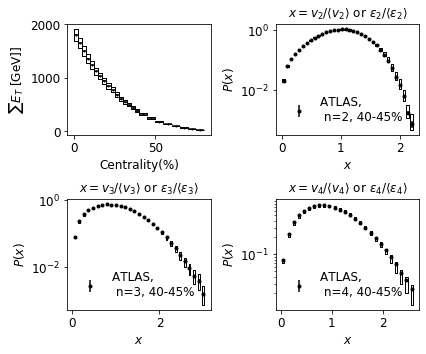

In [9]:
fig, axes = plt.subplots(figsize=(6,5), ncols=2,nrows=2)
plot_exp(axes.flatten())

Next, overlay our calculaton at the design porints to the experimental value. Which observable might help to contrain the parameters?

In [10]:
def plot_design(obs, axes):    
    # Since we did not include the noramlization in the design calcualtion,
    # We simple multiply by the calcualtion by unifrom distributed random 
    # varaible to show the spread of prediction stems from a varying normalization.
    for key in obs:
        it = obs[key]
        axes[0].plot(it['ET']['x'], 
                 it['ET']['y']*np.random.uniform(6,16),
                 color='b', 
                 alpha=0.1
        )
    axes[0].set_xlabel("Centrality(%)")
    axes[0].set_ylabel(r"$\sum E_T$ [GeV]]")
    
    cenL, cenH = 40, 45
    for ax, n in zip(axes[1:], [2,3,4]):
        for key in obs:
            it = obs[key]
            ax.plot(it['Pe{}-{}-{}'.format(n,cenL,cenH)]['x'], 
                     it['Pe{}-{}-{}'.format(n,cenL,cenH)]['y'],
                     color='b', 
                     alpha=0.1
            )
        ax.semilogy()
        ax.set_xlabel(r"$x$")
        ax.set_ylabel(r"$P(x)$")
        ax.set_title(r"$x = v_{}/\langle v_{} \rangle$ or $\epsilon_{}/\langle \epsilon_{} \rangle$".format(n,n,n,n))
        
    plt.tight_layout(True)

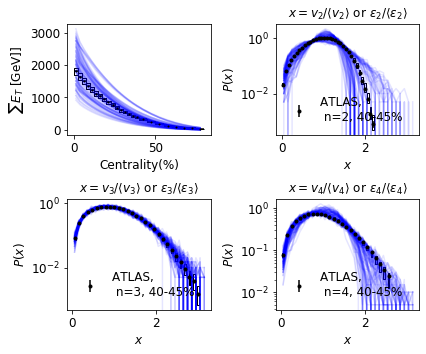

In [11]:
obs = LoadAndComputeObs()
fig, axes = plt.subplots(figsize=(6,5), ncols=2,nrows=2)
plot_exp(axes.flatten())
plot_design(obs, axes.flatten())

It is hard to directly compare the distribution of $v_n/\langle \langle v_n\rangle$ with $\epsilon_n/\langle \langle \epsilon_n\rangle$ in the Bayesian analysis. Because it requrires very high statistics to get the detil of the tails of the distribution. Therefore we choose to compare the standard-deviation and skewness of the distribution. The list of our observables are:
$$ Y_{\textrm{calc}} = \left[ \frac{dE_T}{d\eta}[0-2.5\%],\cdots, \frac{dE_T}{d\eta}[75-80\%], \sigma_{\tilde{\epsilon}_2}[20-25\%]   \cdots, \gamma_{\tilde{\epsilon}_4}[20-25\%], \sigma_{\tilde{\epsilon}_2}[40-45\%]   \cdots, \gamma_{\tilde{\epsilon}_4}[40-45\%]  \right] $$

Consturct $Y_{\textrm{calc}}$

In [12]:
def organize_model_data():
    model_data = np.array([
        [ *list(obs[it]['ET']['y']), 
            obs[it]['Me2-20-25']['std'], obs[it]['Me3-20-25']['std'], obs[it]['Me4-20-25']['std'], 
            obs[it]['Me2-40-45']['std'],  obs[it]['Me3-40-45']['std'], obs[it]['Me4-40-45']['std'],
            obs[it]['Me2-20-25']['skew'], obs[it]['Me3-20-25']['skew'], obs[it]['Me4-20-25']['skew'], 
            obs[it]['Me2-40-45']['skew'], obs[it]['Me3-40-45']['skew'], obs[it]['Me4-40-45']['skew']
        ]  for it in obs 
    ])

def load_precalculated_model_data(filename="ModelData/training-data/design-obs.h5"):
    with h5py.File(filename, "r") as f:
        N = len(f.keys())
        model_data = np.array([
                f["{:d}".format(i)].value  for i in range(N)
            ])   
    return model_data
model_data = load_precalculated_model_data()   

Violin plot:

In [13]:
def plot_design_2(model_data, axes):    
    for it in model_data:
        axes[0].plot(obs['0']['ET']['x'], 
                     it[:-12]*np.random.uniform(6,16), 
                     color='b', alpha=0.1)
    axes[0].set_xlabel("Centrality(%)")
    axes[0].set_ylabel(r"$E_T$")
    axes[1].violinplot(model_data[:,-12:], np.arange(12), showextrema=False, widths=1)
    axes[1].set_xticks(np.arange(12))
    axes[1].set_xticklabels([r"$\sigma_2$, 20-25%",r"$\sigma_3$, 20-25%",r"$\sigma_4$, 20-25%",
                             r"$\sigma_2$, 40-45%",r"$\sigma_3$, 40-45%",r"$\sigma_4$, 40-45%",
                             r"$\gamma_2$, 20-25%",r"$\gamma_3$, 20-25%",r"$\gamma_4$, 20-25%",
                             r"$\gamma_2$, 40-45%",r"$\gamma_3$, 40-45%",r"$\gamma_4$, 40-45%",], rotation=70)
    axes[1].set_ylabel(r"Moments of $P(\epsilon_2/\langle\epsilon_n \rangle)$")
    plt.tight_layout(True)

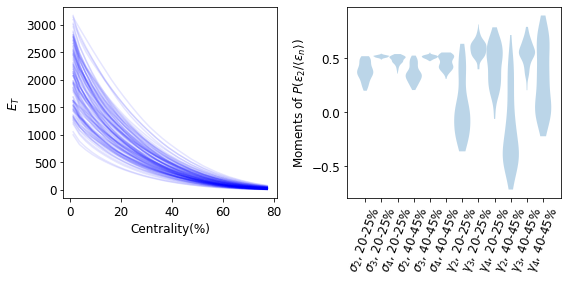

In [14]:
fig, axes = plt.subplots(figsize=(8,4), ncols=2)
plot_design_2(model_data, axes)

## Dimensional reduction via Principal Component Analysis (PCA)

In [15]:
class Standardlization_PCA:
    def __init__(self, data, Npc):
        self.npc = Npc
        self.scaler = StandardScaler(copy=True)
        self.pca = PCA(copy=True, whiten=True, svd_solver='full')

        # Store the first Npc tranformed observables
        self.TransformedObs = self.pca.fit_transform(self.scaler.fit_transform(data))[:,:Npc]
        # Features of each PC
        self.Features = self.pca.components_
        # The transformation matrix from PC to Physical space
        print(self.pca.components_.shape, self.pca.explained_variance_.shape,  self.scaler.scale_.shape)
        self.TransformationMatrix = (np.sqrt(self.pca.explained_variance_[:Npc])\
                                    * self.pca.components_[:Npc,:].T).T \
                                    * self.scaler.scale_

        A = (np.sqrt(self.pca.explained_variance_[Npc:])\
            * self.pca.components_[Npc:,:].T).T \
            * self.scaler.scale_
        self.ResidualCov = np.dot(A.T*1., A)
        # cumulative sum of the explained variance
        self.CumulativeVariance = np.cumsum(self.pca.explained_variance_ratio_)
    def PC2Obs(self, PCs):
        return np.dot(PCs, self.TransformationMatrix) + self.scaler.mean_
    def PCcov2Obscov(self, PCcov, with_truncation_err=True):
        results = np.matmul(self.TransformationMatrix.T*PCcov, self.TransformationMatrix)
        if with_truncation_err:
            return results+self.ResidualCov
        else:
            return results
        

(36, 36) (36,) (36,)


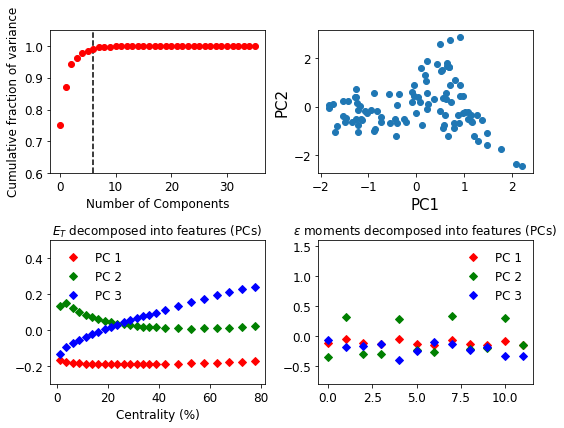

In [16]:
npc = 6

transformer = Standardlization_PCA(model_data, Npc=npc)
fig, ((ax1, ax2),(ax3, ax4)) = plt.subplots(ncols=2, nrows=2,
                                            figsize=(8,6))

ax1.plot(transformer.CumulativeVariance,'ro')
ax1.set_xlabel('Number of Components')
ax1.set_ylabel('Cumulative fraction of variance')
ax1.vlines(npc, .6, 1.2, linestyles='dashed')
ax1.set_ylim(.6,1.05)

ax2.scatter(transformer.TransformedObs[:, 0], 
            transformer.TransformedObs[:, 1])
ax2.set_xlabel('PC1', fontsize=15)
ax2.set_ylabel('PC2', fontsize=15)

for i, (it, color) in \
        enumerate(zip(transformer.Features, 'rgb')):
    ax3.plot(obs['0']['ET']['x'],it[:24], 'D', color=color, label='PC {}'.format(i+1))
ax3.set_xlabel('Centrality (%)')
ax3.set_title(r"$E_T$ decomposed into features (PCs)")
ax3.legend()
ax3.set_ylim(-.3, .5)


for i, (comp, color) in \
        enumerate(zip(transformer.Features, 'rgb')):
    ax4.plot(comp[24:], 'D', color=color, label='PC {}'.format(i+1))
ax4.set_title(r"$\epsilon$ moments decomposed into features (PCs)")
ax4.legend()
ax4.set_ylim(-.8,1.6)

plt.tight_layout(True)

## Step 4:Training emulators

In [17]:
kernel = (
    1. * kernels.RBF(
        length_scale=[1]*4,
        length_scale_bounds=[(.2,100.)]*4
    )  
    + kernels.WhiteKernel(
        noise_level=1., 
        noise_level_bounds=(1e-3, 1e2))
)

# Build and train each GP
gps = [ GPR(kernel=kernel, n_restarts_optimizer=4) 
        for i in range(npc) ]
for i, gp in enumerate(gps):
    gp.fit(Design.T, transformer.TransformedObs[:,i])
    print('RBF: ', gp.kernel_.get_params()['k1'])
    print('White: ', gp.kernel_.get_params()['k2'])

RBF:  1.68**2 * RBF(length_scale=[0.991, 0.681, 5.65, 61.3])
White:  WhiteKernel(noise_level=0.001)
RBF:  2.87**2 * RBF(length_scale=[1.24, 1.62, 4.48, 15.4])
White:  WhiteKernel(noise_level=0.05)
RBF:  1.45**2 * RBF(length_scale=[0.63, 0.808, 5.08, 14.8])
White:  WhiteKernel(noise_level=0.0523)
RBF:  0.776**2 * RBF(length_scale=[0.621, 0.258, 100, 0.2])
White:  WhiteKernel(noise_level=0.505)
RBF:  1.35**2 * RBF(length_scale=[0.394, 0.692, 1.95, 7.36])
White:  WhiteKernel(noise_level=0.104)
RBF:  0.757**2 * RBF(length_scale=[0.625, 0.335, 0.688, 3.12])
White:  WhiteKernel(noise_level=0.516)


## Step 5: Emulator validation

In [18]:
#ParamRanges = {"p": [-1, 1],
#               "w": [0.4, 1.5],
#               "s": [1./3., 3.],
#               "v": [0, 2.],
#               "N": [6,16]
validation_parameters = np.array([
    [.2, .5, 1.2, .3],
    [.5, .7, 1.4, 1.2],
    [-.5, 1., .7, 1.],
])
#call_TRENTo(*(validation_parameters.T), save2file="validation-data.h5")

In [19]:
def GP_pred_at_one_input(parameter, with_truncation_err=True):
    pcs, pcstd = np.array([gp.predict([parameter], return_std=True) for gp in gps]).T[0]
    pred = transformer.PC2Obs(pcs)
    pred_err = np.sqrt( np.diag( transformer.PCcov2Obscov(pcstd**2, with_truncation_err) ) )
    return pred, pred_err

In [ ]:
ValidatingData = LoadAndComputeObs(filename="ModelData/trento-data/validation-raw.h5")
fig, (ax1, ax2, ax3) = plt.subplots(ncols=3, figsize=(9,4))
for parameter, key, color in zip(validation_parameters, ValidatingData, 'rgb'):
    yobs = ValidatingData[key]
    calc = np.array([
                *list(yobs['ET']['y']), 
                yobs['Me2-20-25']['std'], yobs['Me3-20-25']['std'], yobs['Me4-20-25']['std'], 
                yobs['Me2-40-45']['std'], yobs['Me3-40-45']['std'], yobs['Me4-40-45']['std'],
                yobs['Me2-20-25']['skew'], yobs['Me3-20-25']['skew'], yobs['Me4-20-25']['skew'], 
                yobs['Me2-40-45']['skew'], yobs['Me3-40-45']['skew'], yobs['Me4-40-45']['skew']
               ])
    # GP prediction
    pred, pred_err = GP_pred_at_one_input(parameter, with_truncation_err=True)
    # model calcuatlion
    ax1.errorbar(yobs['ET']['x'], pred[:-12]/calc[:-12], yerr=pred_err[:-12]/calc[:-12], fmt=color+'.', alpha=0.7)
    ax2.errorbar(np.arange(6), pred[-12:-6]/calc[-12:-6], yerr=pred_err[-12:-6]/calc[-12:-6], fmt=color+'.', alpha=0.7)
    ax3.errorbar(np.arange(6), pred[-6:]-calc[-6:], yerr=pred_err[-6:], fmt=color+'.', alpha=0.7)
    
ax1.set_xlabel('Centrality (%)')
ax1.set_ylabel(r'$\sum E_T$: Pred / Calc')
ax2.set_ylabel(r'std ${\epsilon_n}$: Pred / Calc')
ax3.set_ylabel(r'skew ${\epsilon_n}$: Pred - Calc')
ax1.set_ylim(.75,1.25)
ax2.set_ylim(.75,1.25)
ax3.set_ylim(-.5, .5)
ax2.set_xticks(np.arange(6))
ax2.set_xticklabels(
    [r"$\sigma_2$, 20-25%",r"$\sigma_3$, 20-25%",r"$\sigma_4$, 20-25%",
    r"$\sigma_2$, 40-45%",r"$\sigma_3$, 40-45%",r"$\sigma_4$, 40-45%"],
    rotation=70)
ax3.set_xticks(np.arange(6))
ax3.set_xticklabels(
    [r"$\gamma_2$, 20-25%",r"$\gamma_3$, 20-25%",r"$\gamma_4$, 20-25%",
    r"$\gamma_2$, 40-45%",r"$\gamma_3$, 40-45%",r"$\gamma_4$, 40-45%",],
    rotation=70)


plt.tight_layout(True)



## Step 6 Model-to-data comparison

### 6.1 Choose the ''experimental'' data

1. Pseudo-data : let us use one of the validation point as the pseudo data
2. Experimental data.

In [21]:
UsePseudoData = False
PseudoDataIdx = 0
if UsePseudoData:
    Norm = 12.
    yobs = ValidatingData['{:d}'.format(PseudoDataIdx)]
    parameter_truth = list(validation_parameters[PseudoDataIdx])+[Norm]
    yexp = np.array([
                *list(yobs['ET']['y']*Norm), 
                yobs['Me2-20-25']['std'], yobs['Me3-20-25']['std'], yobs['Me4-20-25']['std'], 
                yobs['Me2-40-45']['std'], yobs['Me3-40-45']['std'], yobs['Me4-40-45']['std'],
                yobs['Me2-20-25']['skew'], yobs['Me3-20-25']['skew'], yobs['Me4-20-25']['skew'], 
                yobs['Me2-40-45']['skew'], yobs['Me3-40-45']['skew'], yobs['Me4-40-45']['skew']
               ])
    ystat = np.array([
                *list(yobs['ET']['stat']*Norm), 
                yobs['Me2-20-25']['std-err'], yobs['Me3-20-25']['std-err'], yobs['Me4-20-25']['std-err'], 
                yobs['Me2-40-45']['std-err'], yobs['Me3-40-45']['std-err'], yobs['Me4-40-45']['std-err'],
                yobs['Me2-20-25']['skew-err'], yobs['Me3-20-25']['skew-err'], yobs['Me4-20-25']['skew-err'], 
                yobs['Me2-40-45']['skew-err'], yobs['Me3-40-45']['skew-err'], yobs['Me4-40-45']['skew-err']
               ])
    ysys = np.zeros_like(ystat)
    print("Using pseudo-data")
    print("Truth of parameters: ")
    print("p={:1.3f}, w={:1.3f}, s={:1.3f}, v={:1.3f}, N={:1.3f}".format(*parameter_truth))
else:
    print("Using exp-data")
    ET, ETstat, ETsys = np.loadtxt("ExpData/ALICE-ET.dat",usecols=[3,4,6]).T
    yexp = list(ET)
    ystat = list(ETstat)
    ysys = list(ETsys)
    # compute std and skew from the distribution
    for mom in ['std','skew']:
        for (cenL, cenH) in [(20,25),(40,45)]:
            for n in [2,3,4]:
                x, y, stat, sp, sm = np.loadtxt("ExpData/ATLAS-Pv{}-{}-{}.dat".format(n,cenL,cenH), 
                                            usecols=[0,1,2,4,5]).T
                
                # sacle the mean
                f = interp1d(x, y, kind='linear')
                X = np.linspace(x.min(),x.max(),100)
                xmean = (f(X)*X).sum()/f(X).sum()
                std = np.average( (X/xmean-1.)**2, weights= f(X) )**.5
                skew = np.average( (X/xmean-1.)**3, weights= f(X) ) / std**3
                if mom=='std':
                    yexp = yexp + [std]
                if mom == 'skew':
                    yexp = yexp + [skew]
                ysys = ysys + [std*.05]
                ystat = ystat + [skew*.05]    
    yexp = np.array(yexp)
    ysys = np.array(ysys)
    ystat = np.array(ystat)

Using exp-data


In [22]:
##### Helper functions for this block ###################
from scipy.linalg import lapack
# calculate the log of Gaussian density with 
# residual dy = y-mu and covariance matrix cov.
# - 1/2 * dy^T * cov^[-1] * dy - 1/2*ln(|cov|)
def lnLL(dy, cov):
    L, info = lapack.dpotrf(cov, clean=False)
    alpha, info = lapack.dpotrs(L, dy)
    return -.5*np.dot(dy, alpha)-np.log(L.diagonal()).sum()

####### Step 5: Construct the posterior #################
def prior_ln_pdf(theta):
    if (theta<ranges[:,0]).any() or (theta>ranges[:,1]).any():
        return -np.inf
    else:
        return 0.

cov_exp = np.diag(ystat**2) + np.diag(ysys**2)

def likelihood_ln_pdf(theta):
    Norm = theta[-1]
    pcs, pcstd = np.array([gp.predict([theta[:-1]], return_std=True) for gp in gps]).T[0]
    pred = transformer.PC2Obs(pcs)
    cov_pred = transformer.PCcov2Obscov(pcstd**2, with_truncation_err=True)
    pred[:24] *= Norm
    cov_pred[:24,:] *= Norm
    cov_pred[:,:24] *= Norm
    dy = pred-yexp
    cov = cov_exp + cov_pred
    return lnLL(dy, cov)

# Finally ln(Posterior) = ln(prior) + ln(likelihood)
def posterior_ln_pdf(theta):
    ln_pr = prior_ln_pdf(theta)
    ln_like = likelihood_ln_pdf(theta) 
    return ln_pr + ln_like

In [23]:
def MCMC_generate(ranges, nsteps=1000, nburnin=200, ndim=5, nwalkers=100):
    sampler = emcee.EnsembleSampler(nwalkers, ndim, posterior_ln_pdf)
    # Burn in steps
    p0 = np.random.rand(nwalkers, ndim)
    p0 = (1.-p0)*ranges[:, 0] +  p0*ranges[:, 1]
    sampler.run_mcmc(p0, nburnin)
    # Production run
    p1 = sampler.chain[:,-1,:]
    sampler.run_mcmc(p1, nsteps)
    return sampler.chain.reshape((-1, ndim))

def Load_MCMC_chain(UsePseudoData, PseudoDataIdx, file='chain.h5'):
    with h5py.File(file, 'r') as f:
        if not UsePseudoData:
            samples = f['real-data'].value
        else:
            samples = f['validation-{:d}'.format(PseudoDataIdx)].value
    return samples

def Write_MCMC_chain(data, parameter_truth, UsePseudoData, PseudoDataIdx, file='chain.h5'):
    with h5py.File(file, 'a') as f:
        if not UsePseudoData:
            f.create_dataset("real-data", data=data, dtype=np.float)
        else:
            d = f.create_dataset('validation-{:d}'.format(PseudoDataIdx), data=data, dtype=np.float)
            d.attrs['truth'] = parameter_truth
    return samples

In [24]:
ndim = 5
# load pre-generated chain
#samples = Load_MCMC_chain(UsePseudoData, PseudoDataIdx)

# Generate your own chain, don't use this with the online Binder server, it is slow!
# Use it if you are using your own computer
samples = MCMC_generate(ranges=ranges, nsteps=1000, nburnin=500, ndim=5, nwalkers=100)


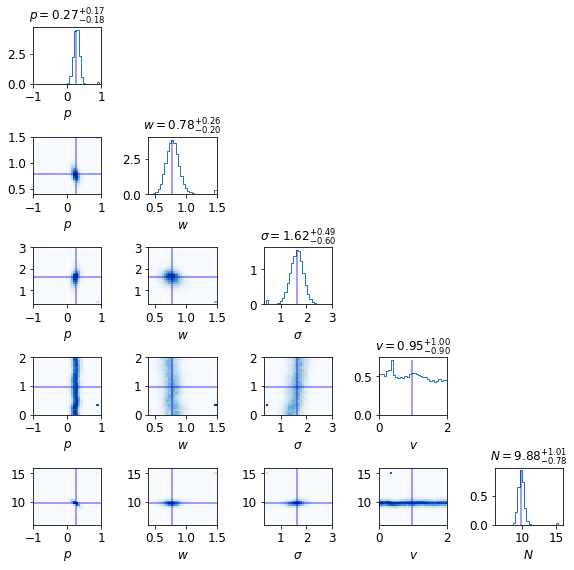

In [26]:
##### Step 7: Analyze the posterior distribution ########
# 1) Run this block and plot the posterior distribution
# 2) Does the posterior fairly estimates the true values (red)?
# 3) How does the posterior change it we take into account the
#    correlation among the sys-error?
figure, axes = plt.subplots(figsize=(8,8), 
                            ncols=ndim, nrows=ndim)
names = [r"$p$",r"$w$",r"$\sigma$",r"$v$",r"$N$"]
for i, row in enumerate(axes):
    for j, ax in enumerate(row):
        if i==j:
            H, _,  _ = ax.hist(samples[:,i], bins=30,
                    range=ranges[i], histtype='step', 
                    density=True)
            if UsePseudoData:
                ax.vlines(parameter_truth[i],0,H.max(),color='r',alpha=0.5)
            xmedian = np.quantile(samples[:,i],.5)
            x2d5 = np.quantile(samples[:,i],.025)
            x97d5 = np.quantile(samples[:,i],.975)
            ax.vlines(xmedian,0,H.max(),color='b',alpha=0.5)
            ax.set_title(names[i]+r"$={:1.2f}_{{-{:1.2f}}}^{{+{:1.2f}}}$".format(xmedian,xmedian-x2d5,x97d5-xmedian))
            ax.set_xlabel(names[i])
            ax.set_xlim(*ranges[j])
        if i>j:
            ax.hist2d(samples[:, j], samples[:, i], 
                      bins=30, range=[ranges[j], ranges[i]], 
                      cmap='Blues')
            if UsePseudoData:
                ax.hlines(parameter_truth[i],*ranges[j],color='r',alpha=0.5)
                ax.vlines(parameter_truth[j],*ranges[i],color='r',alpha=0.5)
            ax.hlines(np.quantile(samples[:,i],.5),*ranges[j],color='b',alpha=0.5)
            ax.vlines(np.quantile(samples[:,j],.5),*ranges[i],color='b',alpha=0.5)
            ax.set_xlabel(names[j])
            ax.set_xlim(*ranges[j])
            ax.set_ylim(*ranges[i]) 
        if i<j:
            ax.axis('off')
plt.tight_layout(True)
#plt.savefig("corr-results.png")

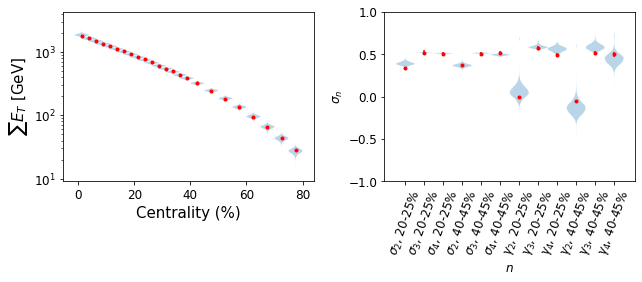

In [29]:
# predicting observables
param_samples = samples[np.random.choice(range(len(samples)),1000), :]
Norms = param_samples[:,-1]
pred = np.array([
    GP_pred_at_one_input(theta[:-1], with_truncation_err=True)[0]
    for theta in param_samples
])
pred[:,:24] = (Norms*pred[:,:24].T).T

fig, (ax1, ax2) = plt.subplots(ncols=2,figsize=(9,4))
ax1.violinplot( pred[:,:-12],obs['0']['ET']['x'], widths=5, showextrema=False)
ax1.errorbar(obs['0']['ET']['x'],yexp[:-12], yerr=ystat[:-12], fmt='r.', label="Measurements")
ax1.semilogy()
ax1.set_xlabel(r'Centrality (%)', fontsize=15)
ax1.set_ylabel(r'$\sum E_T$ [GeV]', fontsize=15)

ax2.violinplot( pred[:,-12:],np.arange(12), showextrema=False, widths=1)
ax2.errorbar(np.arange(12), yexp[-12:], yerr=ystat[-12:], fmt='r.', label="Measurements")
ax2.set_xticks(np.arange(12))
ax2.set_xticklabels([r"$\sigma_2$, 20-25%",r"$\sigma_3$, 20-25%",r"$\sigma_4$, 20-25%",
                   r"$\sigma_2$, 40-45%",r"$\sigma_3$, 40-45%",r"$\sigma_4$, 40-45%",
                 r"$\gamma_2$, 20-25%",r"$\gamma_3$, 20-25%",r"$\gamma_4$, 20-25%",
                r"$\gamma_2$, 40-45%",r"$\gamma_3$, 40-45%",r"$\gamma_4$, 40-45%",], rotation=70)
ax2.set_xlabel(r"$n$")
ax2.set_ylabel(r"$\sigma_{n}$")
ax2.set_ylim(-1,1)
plt.tight_layout(True)

## Predicting $\sum E_T$ and the full distribution of $\epsilon/\langle\epsilon\rangle$ using the Maximum a Posteriori (MAP)

MAP is the parameter set that maximizes the posterior distribution. It can be loosely understand as a "best fit" result from the analysis. Nevertheless, it does not take into account the full prediciton uncertianty, and the location of the MAP can be sensitive to the choice of prior. Therefore, these values cannot be understood as a unique set of parameters that should be considered superior to other chices sampled from the posterior distribution.


In [30]:
from scipy.optimize import minimize

# we minimize the negative of ln(Posterior), 
# with initial guess in the middle of the prior
result = minimize(lambda x: -posterior_ln_pdf(x), 
                  method='CG',
                  x0 = [(r[0]+r[1])/2. for r in ranges], 
                  bounds=ranges)
print("MAP parameters:")
print("p={:1.3f}, w={:1.3f}, s={:1.3f}, v={:1.3f}, N={:1.3f}".format(*result['x']))
MAP = result['x']

MAP parameters:
p=0.274, w=0.771, s=1.689, v=1.363, N=9.851


s

In [31]:
#call_TRENTo(*np.atleast_2d(MAP[:4]).T, 100000, "MAP_prediction.h5")

In [32]:
MapObs = LoadAndComputeObs("ModelData/trento-data/MAP_raw.h5")

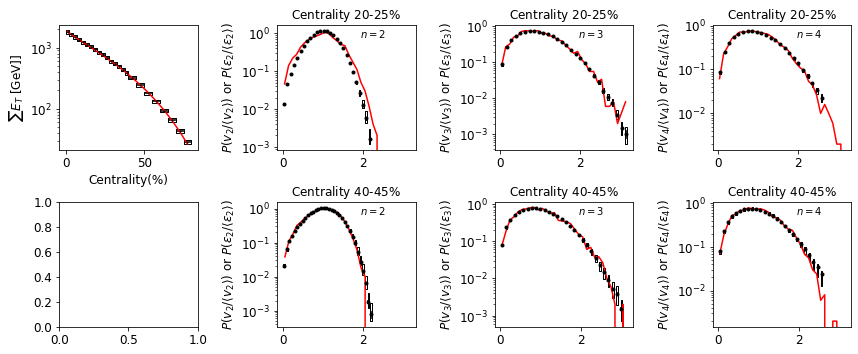

In [33]:
fig, axes = plt.subplots(nrows=2, ncols=4, figsize=(12,5))

x, xl, xh, ET, ETstat, ETsys = np.loadtxt("ExpData/ALICE-ET.dat",usecols=[0,1,2,3,4,6]).T
axes[0,0].errorbar(x, ET, xerr=(xh-xl)/2., yerr=ETstat,label='ALICE',fmt='k.',markersize=2)
for (ixl, ixh, iy, iss) in zip(xl, xh, ET, ETsys):
    axes[0,0].fill_between([ixl,ixh],[iy-iss,iy-iss],
                    [iy+iss,iy+iss],facecolor='none',
                    edgecolor='k')
axes[0,0].set_xlabel("Centrality(%)")
axes[0,0].set_ylabel(r"$\sum E_T$ [GeV]]")
axes[0,0].plot(MapObs['0']['ET']['x'],
             MapObs['0']['ET']['y']*MAP[-1],
             color='r')
axes[0,0].set_xlabel("Centrality(%)")
axes[0,0].semilogy()

for (cenL, cenH), row in zip([(20,25),(40,45)], axes):
    for ax, n in zip(row[1:], [2,3,4]):
        x, y, stat, sp, sm = np.loadtxt("ExpData/ATLAS-Pv{}-{}-{}.dat".format(n,cenL,cenH), 
                                            usecols=[0,1,2,4,5]).T
        f = interp1d(x, y, kind='linear')
        X = np.linspace(x.min(),x.max(),100)
        xmean = (f(X)*X).sum()/f(X).sum()
        ax.errorbar(x/xmean, y*xmean, yerr=stat*xmean, label='ATLAS, n={:d}, {:d}-{:d}%'.format(n,cenL,cenH), fmt='k.')
        for ix, iy, ip, im in zip(x/xmean, y*xmean, sp*xmean, sm*xmean):
            ax.fill_between([ix-.02, ix+.02], [iy+im, iy+im], [iy+ip, iy+ip], edgecolor='k', facecolor='none')
        ax.set_title(r"Centrality ${:d}$-${:d}$%".format(cenL, cenH))
        ax.plot(MapObs['0']['Pe{}-{}-{}'.format(n,cenL,cenH)]['x'], 
                MapObs['0']['Pe{}-{}-{}'.format(n,cenL,cenH)]['y'],
                color='r'
               )
        ax.annotate(r"$n={:d}$".format(n), xy=(.6, .9),  xycoords="axes fraction")
        ax.semilogy()
        ax.set_ylabel(r"$P(v_{}/\langle v_{} \rangle)$ or $P(\epsilon_{}/\langle \epsilon_{} \rangle)$".format(n,n,n,n))
    
plt.tight_layout(True)